In [43]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML
auto_df = pd.read_csv('Auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [27]:
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}
auto_df = pd.read_csv('Auto.csv')
auto_df.replace('?', np.nan, inplace=True)
quants = auto_df[datatypes['quant']].astype(np.float_)

auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

In [29]:
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})

X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

def linear_model(X, y):
    """Estimation of parameteres for linear regressions model
    by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [31]:
# Our handrolled linear model doesn't provide the useful statistics 
# that summary(lm()) would provide in R. 
# For each estimated coefficient we would like to get the follow stats
# - coefficient 
# - standard error
# - t-value
# - p-value

# Add constant for bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})
#Load data
X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

# Predict coefficients and responses
coefficients = linear_model(X, y)
y_pred       = predict(beta, X)


# Calculate Mean Squared Error
MSE = np.sum(np.square(y_pred - y)) / y.size

# Variance of each variable in X
variance = MSE * (np.linalg.inv(X.T @ X).diagonal())  # To discuss: how is variance derived from MSE?

# Standard error of each variable in X
# given by Var(X) = SE(X)^2
standard_error = np.sqrt(variance)

# t-statistic given by t = β - 0 / SE(β)
t_statistic = coefficients / standard_error

# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))


# Present results
results = pd.DataFrame({'feature': X.columns,
                        'coefficients': coefficients,
                        'standard_error': standard_error,
                        't-statistic': t_statistic,
                        'P>|t|': p_values})

results.set_index('feature')

,coefficients,standard_error,t-statistic,P>|t|
feature,,,,
intercept,NaN,NaN,NaN,NaN
horsepower,NaN,NaN,NaN,NaN


In [37]:
# The statsmodels library provides a convenient means to get the
# same statistics
auto_df = auto_df.dropna()  # Drop rows with missing values
auto_df = auto_df.replace([np.inf, -np.inf], np.nan).dropna()  # Drop rows with infinite values
X = auto_df['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto_df['mpg']

results = sm.OLS(y, X).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 30 May 2024   Prob (F-statistic):           7.03e-81
Time:                        08:18:40   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

In [31]:
# predicted mpg associated with a horsepower of 98

def predict(model, X):
    return model.T @ X

X_ex = np.array([1, 98])

y_ex = predict(coefficients, X_ex)
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [33]:
# the associated 95% confidence and prediction intervals

model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [predict(model_min, X_ex), predict(model_max, X_ex)]
print(confidence_interval)

[21.814544959722653, 27.119609345302212]


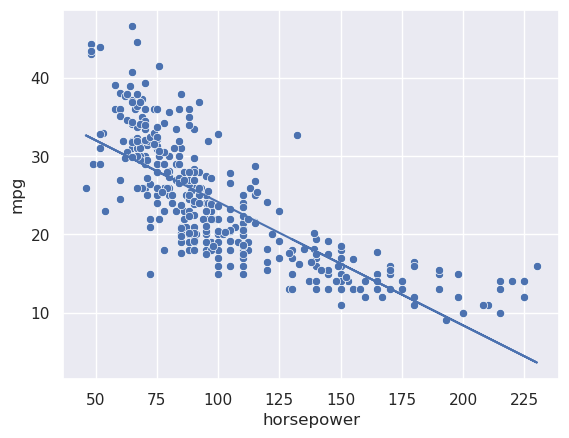

In [35]:
# Let's plot our predicted regression

df = pd.concat([auto_df['horsepower'], auto_df['mpg']], axis=1)
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)
ax.plot(auto_df['horsepower'], y_pred);

In [37]:
def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

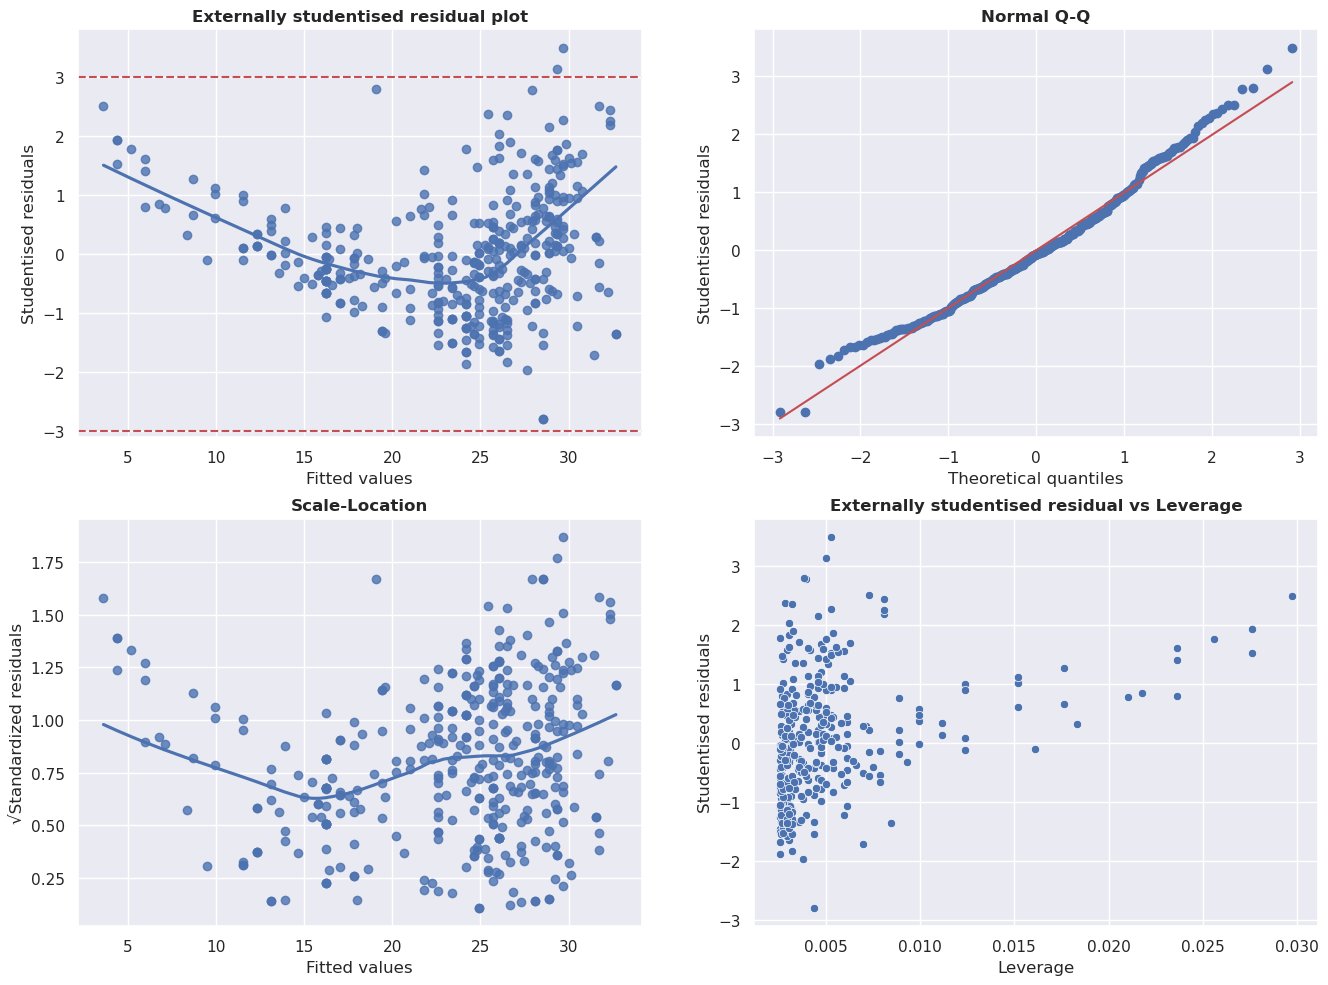

In [39]:
X = pd.concat([auto_df['horsepower']], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = auto_df['mpg']

lm_plot(lm_stats(X, y, y_pred))

In [57]:
print("The above residual plot grid shows the relationship between the horsepower predictor and the mpg response.")
print("There are several things to note: Non-linearity of the data: The top-left residual plot exhibits a discernable pattern,")
print("in this case u-shaped, that suggests our linear model is not providing an optimal fit to our data - the relationship is non-linear.")
print("A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses.")
print("There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.")
print("Heteroscedasticity – Non-constant variance of error terms The top-left residual plot exhibits a conical shape. This suggests")
print("that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting")
print("that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.")
print("Outliers and leverage: the bottom-right residual vs leverage plot suggests that there are several potential outliers")
print("(points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.")
print("The top-right plot shows that our studentised residuals have a slightly non-normal distribution (TODO: elaborate)")

The above residual plot grid shows the relationship between the horsepower predictor and the mpg response.
There are several things to note: Non-linearity of the data: The top-left residual plot exhibits a discernable pattern,
in this case u-shaped, that suggests our linear model is not providing an optimal fit to our data - the relationship is non-linear.
A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses.
There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.
Heteroscedasticity – Non-constant variance of error terms The top-left residual plot exhibits a conical shape. This suggests
that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting
that standardisation doesn't alleviate the issue – to address this we might consider fitting our mode

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

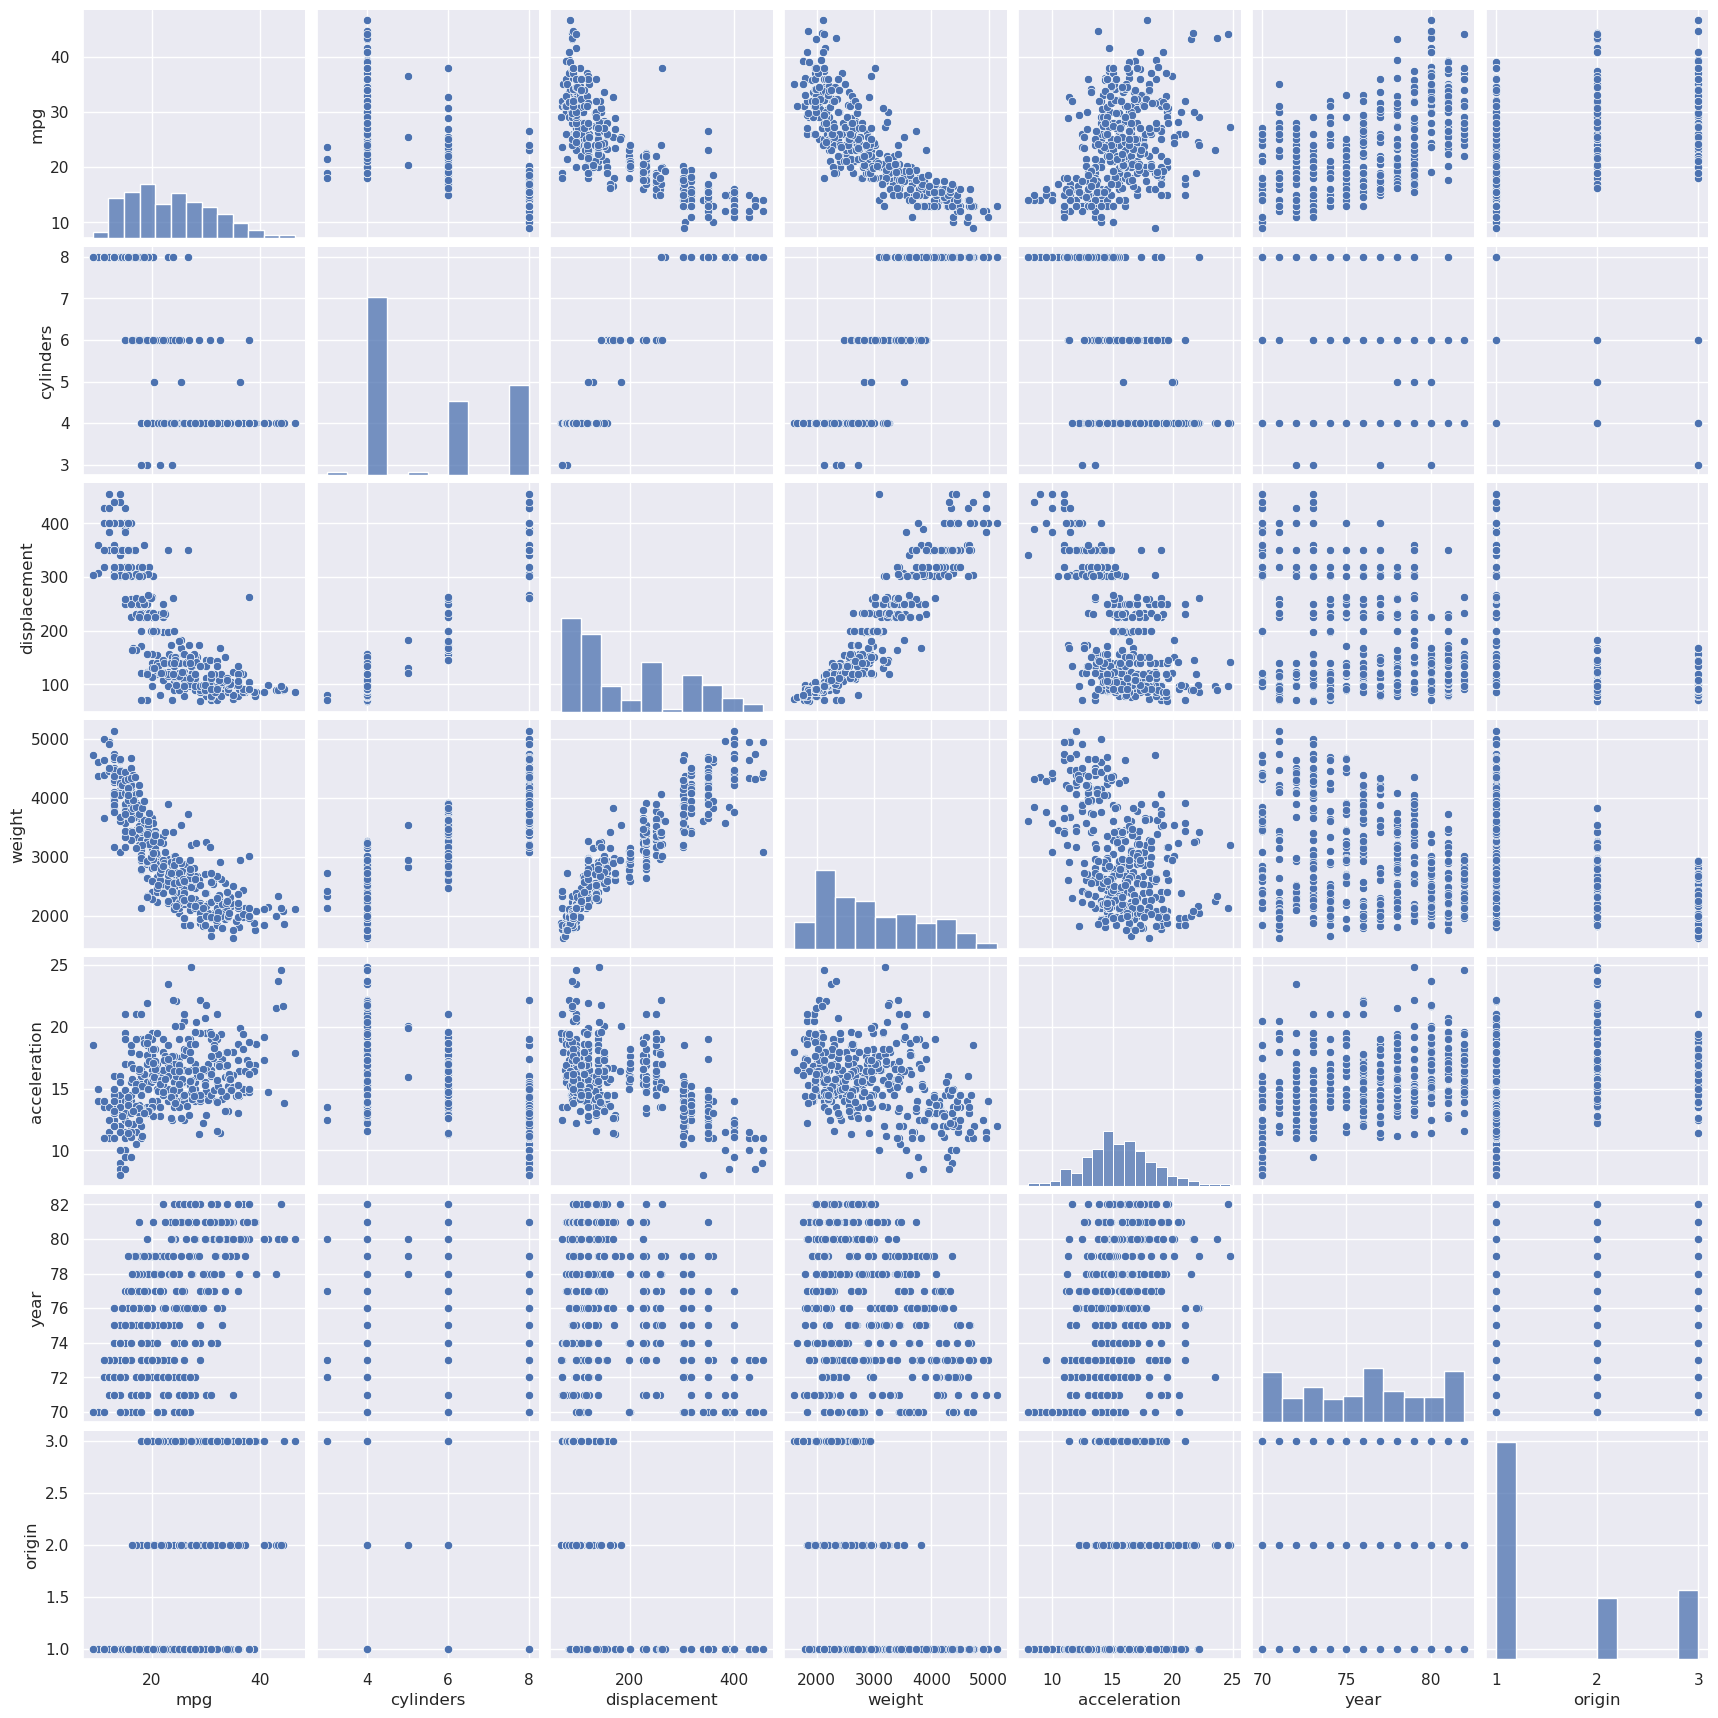

In [82]:
import seaborn as sns
auto_df = pd.read_csv('Auto.csv')
df = pd.DataFrame({'Auto.csv': [1, np.inf, 3]})
df.replace(np.inf, 0, inplace=True)
pd.option_context('mode.use_inf_as_na', True)
df.replace(np.inf, np.nan)
sns.pairplot(auto_df);


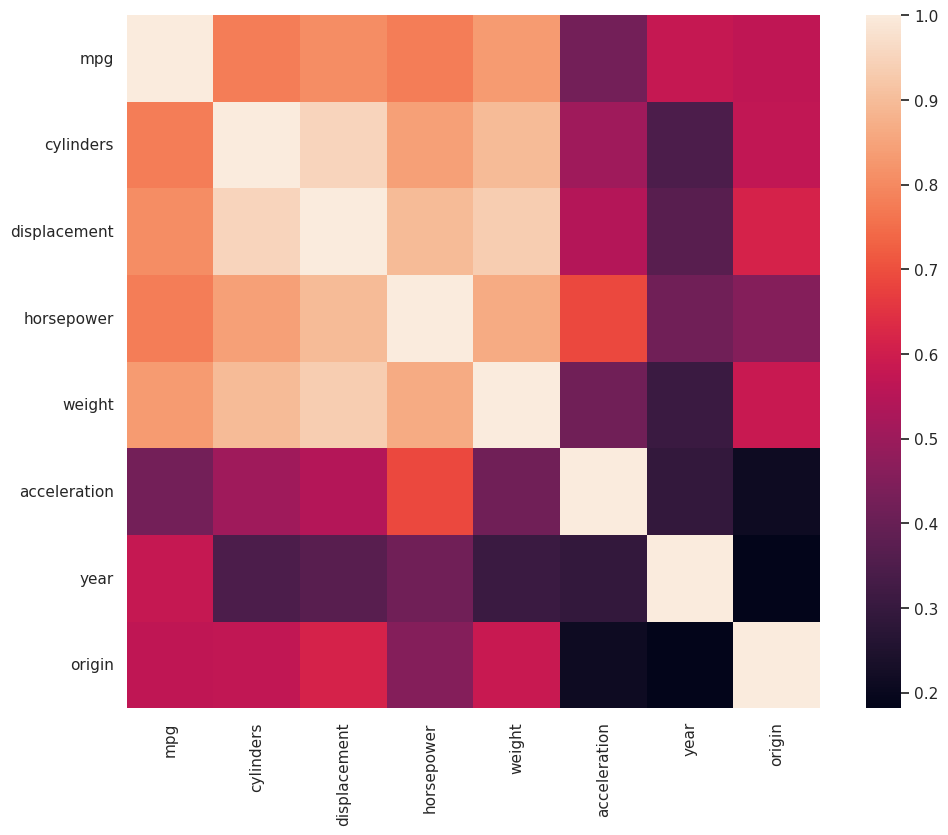

In [131]:
# Assuming you want to drop non-numeric columns
numeric_auto_df = auto_df.select_dtypes(include=['number'])
corr_matrix = numeric_auto_df.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

In [311]:
import patsy 
import statsmodels.api as sm
import statsmodels.formula.api as smf

f = 'mpg ~ horsepower+ cylinders + displacement + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     27.71
Date:                Wed, 29 May 2024   Prob (F-statistic):          2.46e-106
Time:                        12:39:57   Log-Likelihood:                -915.53
No. Observations:                 397   AIC:                             2033.
Df Residuals:                     296   BIC:                             2435.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -19.6655      4.31

In [138]:
model.pvalues[model.pvalues < 0.05].sort_values()


year              1.700511e-44
weight            6.968141e-30
Intercept         5.052117e-07
C(origin)[T.3]    7.172119e-07
C(origin)[T.2]    1.802184e-06
displacement      3.166203e-03
acceleration      3.329348e-02
dtype: float64

In [188]:
# Make predictions
import statsmodels.api as sm
import matplotlib
import statsmodels.formula.api as smf
y_pred = np.array(model.predict(X))
def lm_plot(X, y, y_pred):
    pass  
y_pred = np.array(model.predict(X))

In [218]:
import patsy 
import statsmodels.api as sm
import statsmodels.formula.api as smf
f = 'np.log(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()

# Make predictions
y_pred = np.array(model.predict(X))

In [257]:
model.pvalues[model.pvalues < 0.05].sort_values()

year                 1.044439e-34
Intercept            1.108373e-17
weight               1.519894e-11
horsepower[T.48]     1.440764e-08
horsepower[T.65]     1.167501e-05
horsepower[T.70]     1.848327e-05
horsepower[T.80]     1.594602e-04
horsepower[T.67]     1.971298e-04
horsepower[T.76]     4.256161e-04
horsepower[T.69]     4.366001e-04
C(origin)[T.3]       4.979700e-04
horsepower[T.52]     8.521303e-04
horsepower[T.63]     1.238976e-03
horsepower[T.129]    1.360878e-03
C(origin)[T.2]       5.054593e-03
horsepower[T.58]     8.547930e-03
horsepower[T.?]      1.043124e-02
horsepower[T.75]     1.090864e-02
horsepower[T.64]     1.105340e-02
horsepower[T.83]     1.200346e-02
horsepower[T.193]    1.205817e-02
horsepower[T.200]    1.388822e-02
horsepower[T.90]     1.481354e-02
horsepower[T.60]     1.491750e-02
horsepower[T.66]     1.723969e-02
horsepower[T.133]    1.850673e-02
horsepower[T.180]    2.119187e-02
horsepower[T.53]     2.405870e-02
horsepower[T.61]     2.405989e-02
horsepower[T.8

In [278]:
# Load data
carseats = pd.read_csv('Carseats.csv').drop('Unnamed: 0', axis=1)

# No missing values found

# Pre-processing
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'],
             'qual': ['ShelveLoc', 'Urban', 'US']}
# Use floats for all quantitive values
quants = carseats[datatypes['quant']].astype(np.float_)
carseats_df = pd.concat([quants, carseats[datatypes['qual']]], axis=1)

carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc,Urban,US
0,9.50,138.0,73.0,11.0,276.0,120.0,42.0,17.0,Bad,Yes,Yes
1,11.22,111.0,48.0,16.0,260.0,83.0,65.0,10.0,Good,Yes,Yes
2,10.06,113.0,35.0,10.0,269.0,80.0,59.0,12.0,Medium,Yes,Yes
3,7.40,117.0,100.0,4.0,466.0,97.0,55.0,14.0,Medium,Yes,Yes
4,4.15,141.0,64.0,3.0,340.0,128.0,38.0,13.0,Bad,Yes,No


In [297]:
import patsy 
import statsmodels.api as sm
import statsmodels.formula.api as smf
f = 'Sales ~ Price + C(Urban)+ C(US)'
y, X = patsy.dmatrices(f, carseats_df, return_type='dataframe')

model = sm.OLS(y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Wed, 29 May 2024   Prob (F-statistic):           2.39e-23
Time:                        12:36:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0435      0.651     

In [164]:
import patsy 
import statsmodels.api as sm
import pandas as pn 
import matplotlib 
import statsmodels.formula.api as smf
# Assuming carseats_df is a pandas DataFrame that has been defined or imported earlier in the code
carseats_df = pd.DataFrame({'Sales': [10, 20, 30], 'Price': [100, 200, 300]})
f = 'Sales ~ Price'

# Fit model
model = smf.ols(formula=f, data=carseats_df).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.585e+31
Date:                Thu, 30 May 2024   Prob (F-statistic):           1.60e-16
Time:                        11:54:01   Log-Likelihood:                 97.204
No. Observations:                   3   AIC:                            -190.4
Df Residuals:                       1   BIC:                            -192.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.661e-16   5.43e-15      0.123      0.9

In [179]:
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

#SNS Settings 
sns.set(color_codes = True)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("Set3")

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Import Data Set
import time
time_begin = time.time()

df = pd.read_csv("Auto.csv") # data = pd.read_csv("census.csv")

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins')

Run time: 0.0 mins
